In [25]:
import csv
import pandas as pd
import networkx as nx  


In [26]:
# Lendo arquivo Dataset do IBGE

df = pd.read_csv('resumo_anual_2025.csv', sep=';', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19028 entries, 0 to 19027
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EMPRESA (SIGLA)                    19028 non-null  object 
 1   EMPRESA (NOME)                     19028 non-null  object 
 2   EMPRESA (NACIONALIDADE)            19028 non-null  object 
 3   ANO                                19028 non-null  int64  
 4   MS                                 19028 non-null  int64  
 5   AEROPORTO DE ORIGEM (SIGLA)        19028 non-null  object 
 6   AEROPORTO DE ORIGEM (NOME)         19028 non-null  object 
 7   AEROPORTO DE ORIGEM (UF)           14794 non-null  object 
 8   AEROPORTO DE ORIGEM (REGIO)        14794 non-null  object 
 9   AEROPORTO DE ORIGEM (PAS)          19028 non-null  object 
 10  AEROPORTO DE ORIGEM (CONTINENTE)   19028 non-null  object 
 11  AEROPORTO DE DESTINO (SIGLA)       19028 non-null  obj

In [27]:
df.head()

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIO),AEROPORTO DE ORIGEM (PAS),...,COMBUSTVEL (LITROS),DISTNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,1ED,SERVICIOS AREOS PANAMERICANOS LTDA. SARPA S.A.S,ESTRANGEIRA,2025,4,SBEG,MANAUS,AM,NORTE,BRASIL,...,0.0,1787.0,1.0,0.0,0.0,0.0,0.0,0.0,"2,5",0.0
1,1ED,SERVICIOS AREOS PANAMERICANOS LTDA. SARPA S.A.S,ESTRANGEIRA,2025,4,SBEG,MANAUS,AM,NORTE,BRASIL,...,0.0,1079.0,1.0,0.0,0.0,0.0,0.0,0.0,"1,533",0.0
2,1ED,SERVICIOS AREOS PANAMERICANOS LTDA. SARPA S.A.S,ESTRANGEIRA,2025,4,SKBO,BOGOT,NaN,NaN,COLMBIA,...,0.0,1787.0,1.0,0.0,0.0,0.0,50.0,5000.0,"2,65",0.0
3,1ED,SERVICIOS AREOS PANAMERICANOS LTDA. SARPA S.A.S,ESTRANGEIRA,2025,4,SYCJ,GEORGETOWN,NaN,NaN,GUIANA,...,0.0,2158.0,2.0,0.0,0.0,0.0,100.0,10000.0,"4,783",0.0
4,1ED,SERVICIOS AREOS PANAMERICANOS LTDA. SARPA S.A.S,ESTRANGEIRA,2025,5,SBEG,MANAUS,AM,NORTE,BRASIL,...,0.0,3574.0,2.0,0.0,0.0,0.0,0.0,0.0,"5,1",0.0


In [28]:
# Separando as colunas necessárias para o geomapa
# Renoando as colunas para melhor formatação

df_2025 = df[
    [
        'AEROPORTO DE ORIGEM (SIGLA)', 
        'AEROPORTO DE DESTINO (SIGLA)',
        'AEROPORTO DE ORIGEM (PAS)'
    ]
]

df_2025 = df_2025.rename(
    columns={
        'AEROPORTO DE ORIGEM (SIGLA)': 'AEROPORTO_ORIGEM', 
        'AEROPORTO DE DESTINO (SIGLA)': 'AEROPORTO_DESTINO',
        'AEROPORTO DE ORIGEM (PAS)': 'AEROPORTO_ORIGEM_PAS',
    }
)

df_2025

,AEROPORTO_ORIGEM,AEROPORTO_DESTINO,AEROPORTO_ORIGEM_PAS
0,SBEG,SKBO,BRASIL
1,SBEG,SYCJ,BRASIL
2,SKBO,SBEG,COLMBIA
3,SYCJ,SBEG,GUIANA
4,SBEG,SKBO,BRASIL
...,...,...,...
19023,SBGL,SBEG,BRASIL
19024,SBGL,SVVA,BRASIL
19025,SVMI,SBBR,VENEZUELA
19026,SVMI,SBEG,VENEZUELA


In [29]:
# Verificando se exite valores ausentes

valores_ausentes = df_2025.isnull().sum()
valores_ausentes[valores_ausentes > 0]

Series([], dtype: int64)

In [30]:
df_filtrado = df_2025[df_2025['AEROPORTO_ORIGEM'].str.contains('SNIG')]
df_filtrado

,AEROPORTO_ORIGEM,AEROPORTO_DESTINO,AEROPORTO_ORIGEM_PAS
338,SNIG,SBFZ,BRASIL
528,SNIG,SBFZ,BRASIL


In [31]:
# Lendo dataset com as geolocalizações para um dicionário com a chave sendo a coluna icao
# driando um data frame df_location com pandas
data_dict = {}
with open('iata-icao.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        data_dict[row['icao']] = row 

df_location = pd.read_csv('iata-icao.csv')

In [32]:
# Utilizando o dicionario data_dict para adicionar as colunas de latitude e longitude 
# no dataframe do IBGE de origem e destino, com duas iterações um para adicionar
# as colunas para origem e logo após as colunas para destino.

# ao final tranformando essa colunas para numeric para a construção do grafico não conter erros.

for index, row in df_2025.iterrows():
    codigo = row['AEROPORTO_ORIGEM']
    if codigo in data_dict:
        # Se o código IATA for encontrado no dicionário, atualize as colunas.
        df_2025.loc[index, 'LATITUDE ORIGEM'] = data_dict[codigo]['latitude']
        df_2025.loc[index, 'LONGITUDE ORIGEM'] = data_dict[codigo]['longitude']


for index, row in df_2025.iterrows():
    codigo = row['AEROPORTO_DESTINO']
    if codigo in data_dict:
        # Se o código IATA for encontrado no dicionário, atualize as colunas.
        df_2025.loc[index, 'LATITUDE DESTINO'] = data_dict[codigo]['latitude']
        df_2025.loc[index, 'LONGITUDE DESTINO'] = data_dict[codigo]['longitude']

# Converte as colunas para numericas

df_2025['LATITUDE ORIGEM'] = pd.to_numeric(df_2025['LATITUDE ORIGEM'], errors='coerce')
df_2025['LONGITUDE ORIGEM'] = pd.to_numeric(df_2025['LONGITUDE ORIGEM'], errors='coerce')
df_2025['LATITUDE DESTINO'] = pd.to_numeric(df_2025['LATITUDE DESTINO'], errors='coerce')
df_2025['LONGITUDE DESTINO'] = pd.to_numeric(df_2025['LONGITUDE DESTINO'], errors='coerce')


In [33]:
df_2025.head()

,AEROPORTO_ORIGEM,AEROPORTO_DESTINO,AEROPORTO_ORIGEM_PAS,LATITUDE ORIGEM,LONGITUDE ORIGEM,LATITUDE DESTINO,LONGITUDE DESTINO
0,SBEG,SKBO,BRASIL,-3.03861,-60.0497,4.70159,-74.1469
1,SBEG,SYCJ,BRASIL,-3.03861,-60.0497,6.49855,-58.2541
2,SKBO,SBEG,COLMBIA,4.70159,-74.1469,-3.03861,-60.0497
3,SYCJ,SBEG,GUIANA,6.49855,-58.2541,-3.03861,-60.0497
4,SBEG,SKBO,BRASIL,-3.03861,-60.0497,4.70159,-74.1469


In [34]:
df_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19028 entries, 0 to 19027
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AEROPORTO_ORIGEM      19028 non-null  object 
 1   AEROPORTO_DESTINO     19028 non-null  object 
 2   AEROPORTO_ORIGEM_PAS  19028 non-null  object 
 3   LATITUDE ORIGEM       18445 non-null  float64
 4   LONGITUDE ORIGEM      18445 non-null  float64
 5   LATITUDE DESTINO      18471 non-null  float64
 6   LONGITUDE DESTINO     18471 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.0+ MB


In [35]:
# Checando se as colunas contem dados faltantes após adição das colunas.

valores_ausentes = df_2025.isnull().sum()
valores_ausentes[valores_ausentes > 0]

LATITUDE ORIGEM      583
LONGITUDE ORIGEM     583
LATITUDE DESTINO     557
LONGITUDE DESTINO    557
dtype: int64

In [36]:
# Retirando as colunas com dados faltantes.
# Levando em consideração que os dados faltantes são menos de 1% do dataset.
# dataset contem 19028 entradas e as linhas que contem dados faltantes são 583 no maximo.

df_2025 = df_2025.dropna()

In [37]:
# Checando se as colunas contem dados faltantes após operação dropna.

valores_ausentes = df_2025.isnull().sum()
valores_ausentes[valores_ausentes > 0]

Series([], dtype: int64)

In [38]:
df_2025.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17933 entries, 0 to 19027
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AEROPORTO_ORIGEM      17933 non-null  object 
 1   AEROPORTO_DESTINO     17933 non-null  object 
 2   AEROPORTO_ORIGEM_PAS  17933 non-null  object 
 3   LATITUDE ORIGEM       17933 non-null  float64
 4   LONGITUDE ORIGEM      17933 non-null  float64
 5   LATITUDE DESTINO      17933 non-null  float64
 6   LONGITUDE DESTINO     17933 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [39]:
# Criando um Grafo.
# Nodes aeroportos de origem e destino
# verticies aeroporto de origem para o aeroporto de destino.

G = nx.Graph()

# Vértices e Arestas.
for index, row in df_2025.iterrows():
    G.add_node(row['AEROPORTO_ORIGEM'])
    G.add_node(row['AEROPORTO_DESTINO'])
    G.add_edge(row['AEROPORTO_ORIGEM'], row['AEROPORTO_DESTINO'])

print(G)

Graph with 305 nodes and 1597 edges


In [40]:
# Mapear os nós do grafo para suas posições de latitude e longitude
# Criando dicionário de posições a partir de todas as coordenadas disponíveis no df_2025.
pos_lat_lon = {}

for _, row in df_2025.iterrows():
    # Coletar a posição do aeroporto de origem
    pos_lat_lon[row['AEROPORTO_ORIGEM']] = (row['LATITUDE ORIGEM'], row['LONGITUDE ORIGEM'])
    
    # Coletar a posição do aeroporto de destino
    pos_lat_lon[row['AEROPORTO_DESTINO']] = (row['LATITUDE DESTINO'], row['LONGITUDE DESTINO'])


### Ajustando limites Basemap para montar mapa com a resolução correta.

Você precisa ajustar os limites do Basemap para que ele se concentre na região dos seus aeroportos. O Basemap tem os seguintes parâmetros:

* llcrnrlon: longitude do canto inferior esquerdo (lower-left corner longitude)
* llcrnrlat: latitude do canto inferior esquerdo (lower-left corner latitude)
* urcrnrlon: longitude do canto superior direito (upper-right corner longitude)
* urcrnrlat: latitude do canto superior direito (upper-right corner latitude)

Você deve definir esses valores para que a área do mapa inclua todos os seus pontos de interesse.


### Encontre os limites das suas coordenadas:

Use o seu DataFrame para encontrar os valores mínimos e máximos de latitude e longitude de todos os seus aeroportos.

~~~python
lat_min = min(df_2025['LATITUDE ORIGEM'].min(), df_2025['LATITUDE DESTINO'].min())
lat_max = max(df_2025['LATITUDE ORIGEM'].max(), df_2025['LATITUDE DESTINO'].max())
lon_min = min(df_2025['LONGITUDE ORIGEM'].min(), df_2025['LONGITUDE DESTINO'].min())
lon_max = max(df_2025['LONGITUDE ORIGEM'].max(), df_2025['LONGITUDE DESTINO'].max())
~~~

### Adicione uma margem aos limites:

Para que os aeroportos não fiquem exatamente nas bordas do gráfico, adicione uma pequena margem aos valores que você encontrou. Uma margem de 5 a 10 graus geralmente funciona bem.

~~~Python
margin = 5
llcrnrlat = lat_min - margin
urcrnrlat = lat_max + margin
llcrnrlon = lon_min - margin
urcrnrlon = lon_max + margin
~~~

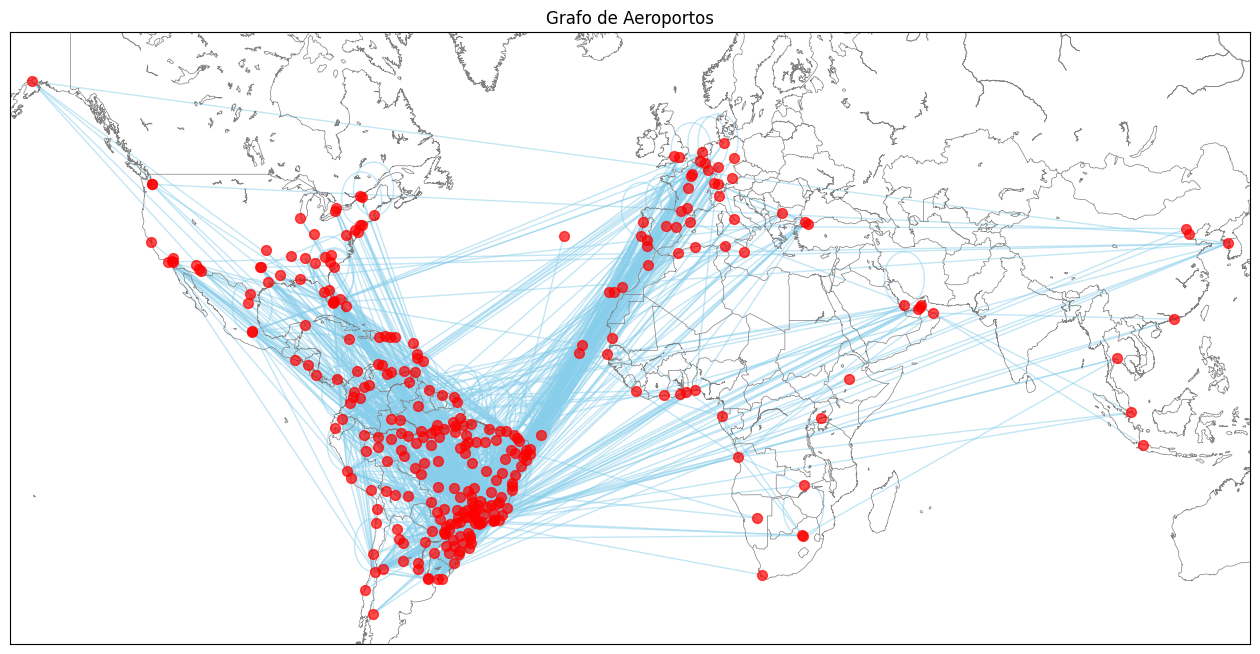

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# 1. Encontrar os limites das coordenadas
lat_min = min(df_2025['LATITUDE ORIGEM'].min(), df_2025['LATITUDE DESTINO'].min())
lat_max = max(df_2025['LATITUDE ORIGEM'].max(), df_2025['LATITUDE DESTINO'].max())
lon_min = min(df_2025['LONGITUDE ORIGEM'].min(), df_2025['LONGITUDE DESTINO'].min())
lon_max = max(df_2025['LONGITUDE ORIGEM'].max(), df_2025['LONGITUDE DESTINO'].max())

# Adicionar margem para não cortar os pontos no mapa
margin = 5  
llcrnrlat = lat_min - margin
urcrnrlat = lat_max + margin
llcrnrlon = lon_min - margin
urcrnrlon = lon_max + margin

fig, ax = plt.subplots(figsize=(16, 12))
basemap = Basemap(
    projection = 'merc',
    llcrnrlon = llcrnrlon,
    llcrnrlat = llcrnrlat,
    urcrnrlon = urcrnrlon,
    urcrnrlat = urcrnrlat,
    resolution = 'l',
    ax = ax)

# Transformar as coordenadas geográficas em coordenadas de plotagem
pos = {}
for node, (lat, lon) in pos_lat_lon.items():
    x, y = basemap(lon, lat)
    pos[node] = (x, y)

# Desenhar as características do mapa
basemap.drawcountries(linewidth=0.5, color='gray')
basemap.drawcoastlines(linewidth=0.5, color='gray')

# Agora, desenhar o grafo
# Use um `nodelist` para garantir que apenas os nós que têm posição sejam desenhados
nodelist_to_draw = [node for node in G.nodes() if node in pos]

nx.draw_networkx_nodes(G = G,
                       pos = pos,
                       nodelist = nodelist_to_draw, # Usar a lista filtrada
                       node_color = 'r',
                       alpha = 0.7,
                       node_size = 50) # Tamanho dos nós

nx.draw_networkx_edges(G = G,
                       pos = pos,
                       edgelist = G.edges(),
                       edge_color = 'skyblue',
                       alpha = 0.5)

plt.title("Grafo de Aeroportos")
plt.show()
